* 1.1 (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_sessions.
* 1.2 (2 pts) Tune the algorithm to end up with positive average score.


In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print("n_states = %i, n_actions = %i" %(n_states,n_actions))

n_states = 500, n_actions = 6


In [4]:
g_policy = np.ones((n_states,n_actions))/n_actions

In [5]:
def generate_session(p_policy, t_max=10**4):
    """
    Play game until end or for t_max ticks
    :param t_max: max ticks 
    :return:  list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(n_actions, p=p_policy[s])
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states, actions, total_reward

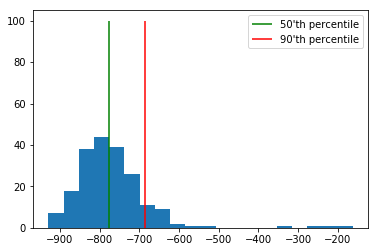

In [6]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(g_policy, t_max=1000)[-1] for _ in range(200)]
plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [
           100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [
           100], label="90'th percentile", color='red')
plt.legend()

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, pp_percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch, pp_percentile)

    
    elite_states  = [states for states, reward in zip(states_batch, rewards_batch) if reward >= reward_threshold]
    elite_actions = [actions for actions, reward in zip(actions_batch, rewards_batch) if reward >= reward_threshold]
    #flatten both lists of lists
    elite_states = [item for sublist in elite_states for item in sublist]
    elite_actions = [item for sublist in elite_actions for item in sublist]
    return elite_states, elite_actions

In [21]:
from IPython.display import clear_output
import os

def show_progress(rewards_batch, log, pp_percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, pp_percentile)
    log.append([mean_reward, threshold])   
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, pp_percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    os.system('cls')
    plt.show()

In [34]:
def train_method(p_policy, p_samples, p_percentile, p_smoothing):
    """
    n_samples = 250 #sample this many samples
    percentile = 30 #take this percent of session with highest rewards
    smoothing = 0.3 #add this thing to all counts for stability
    """
    log = []
    epoch = 0
    for i in range(150):
        sessions_list = [generate_session(p_policy) for __ in range(p_samples)]
        batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions_list))
        p_percentile = 90 - i if 90-i > 30 else 30

        mean_reward = np.mean(batch_rewards)
        if mean_reward > - 60:
            p_percentile = 20
        if i%10 == 0  or mean_reward > -5:
            p_percentile = 10
        if i%15 == 0 and mean_reward < -20:
            p_percentile = 85
        print ("Percentile %.5f" % p_percentile)
        # batch_states: a list of lists of states in each session
        # batch_actions: a list of lists of actions in each session
        # batch_rewards: a list of floats - total rewards at each session
        elite_states, elite_actions = select_elites(batch_states,
                                                    batch_actions,
                                                    batch_rewards,
                                                    pp_percentile=p_percentile)
        elite_counts = np.zeros_like(p_policy) + p_smoothing

        for j in range(len(elite_states)):
            elite_counts[elite_states[j], elite_actions[j]] += 1

        p_policy = elite_counts / elite_counts.sum(1, keepdims=True)

        # display results on chart
    
        show_progress(batch_rewards, log, p_percentile)
        print("epoch ", epoch)
        epoch += 1


Percentile 85.00000
mean reward = -767.556, threshold=-707.150


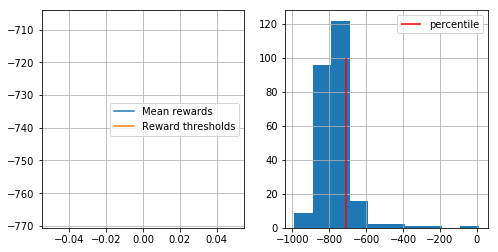

epoch  0


Percentile 89.00000
mean reward = -646.132, threshold=-406.240


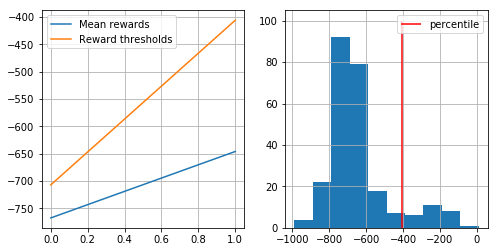

epoch  1


Percentile 88.00000
mean reward = -497.316, threshold=-159.880


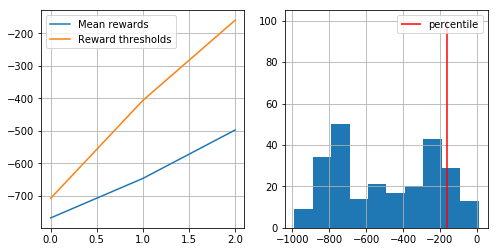

epoch  2


Percentile 87.00000
mean reward = -290.432, threshold=-57.370


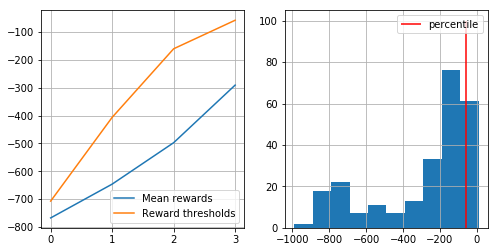

epoch  3


Percentile 86.00000
mean reward = -351.352, threshold=-31.000


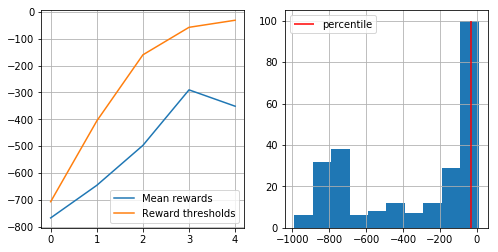

epoch  4


Percentile 85.00000
mean reward = -322.804, threshold=-13.000


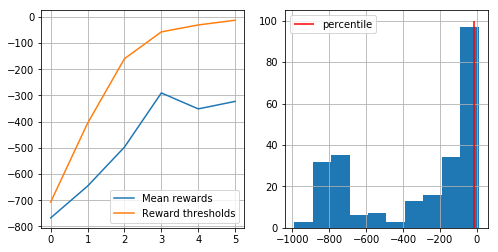

epoch  5


Percentile 84.00000
mean reward = -410.188, threshold=-10.840


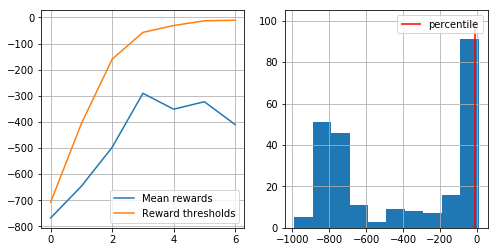

epoch  6


Percentile 83.00000
mean reward = -370.880, threshold=-1.000


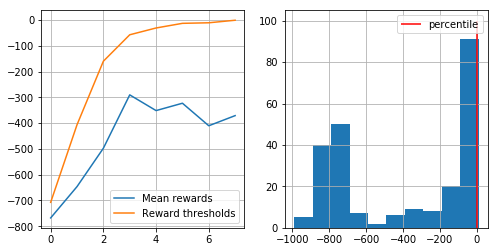

epoch  7


Percentile 82.00000
mean reward = -333.740, threshold=1.000


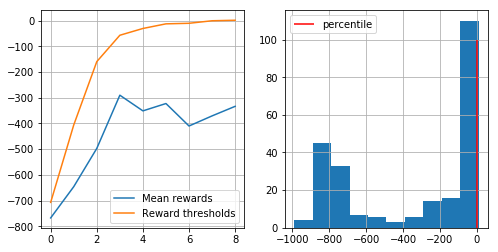

epoch  8


Percentile 81.00000
mean reward = -369.136, threshold=2.000


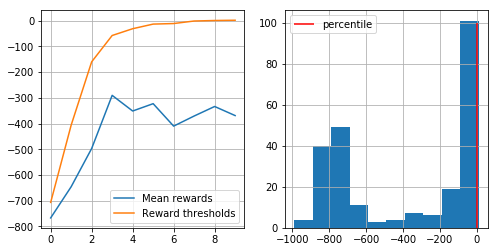

epoch  9


Percentile 10.00000
mean reward = -371.204, threshold=-830.000


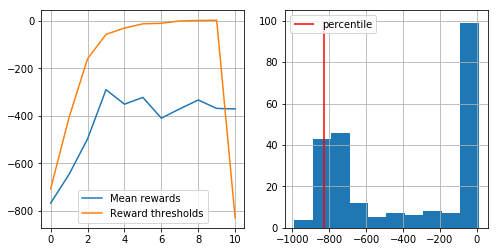

epoch  10


Percentile 79.00000
mean reward = -368.520, threshold=-0.290


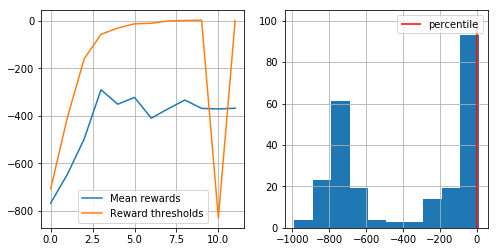

epoch  11


Percentile 78.00000
mean reward = -384.304, threshold=5.000


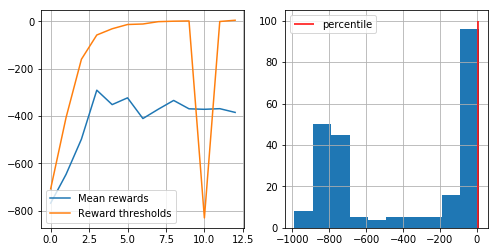

epoch  12


Percentile 77.00000
mean reward = -359.108, threshold=6.000


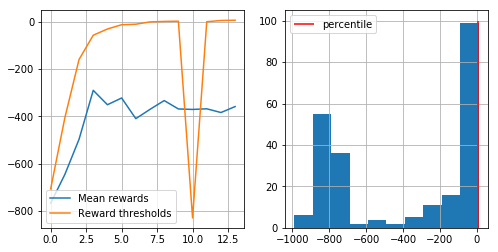

epoch  13


Percentile 76.00000
mean reward = -402.992, threshold=0.480


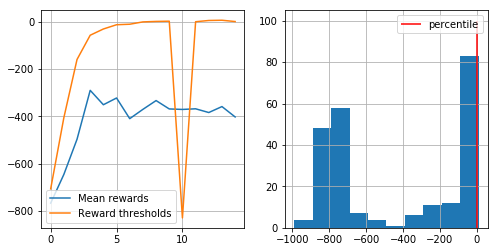

epoch  14


Percentile 85.00000
mean reward = -419.876, threshold=8.000


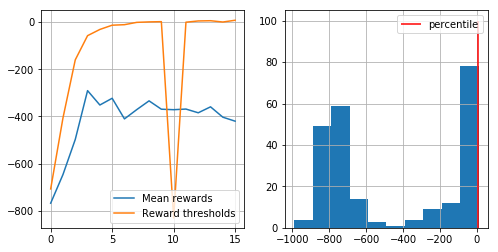

epoch  15


Percentile 74.00000
mean reward = -484.160, threshold=-66.660


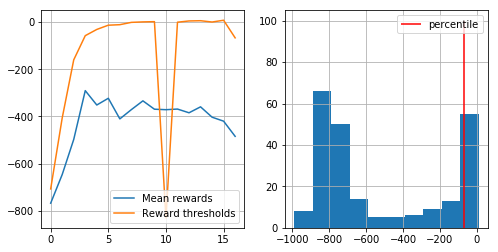

epoch  16


Percentile 73.00000
mean reward = -375.360, threshold=-9.460


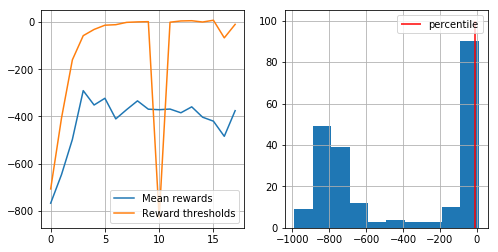

epoch  17


Percentile 72.00000
mean reward = -408.744, threshold=-4.720


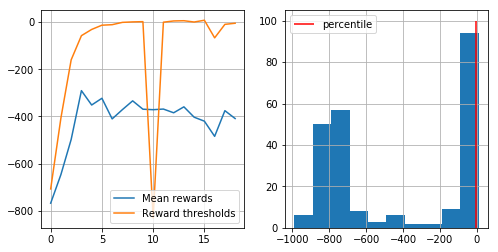

epoch  18


Percentile 71.00000
mean reward = -378.720, threshold=3.000


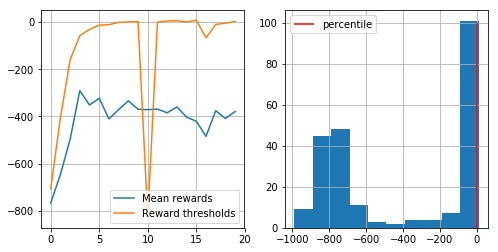

epoch  19


Percentile 10.00000
mean reward = -441.900, threshold=-839.000


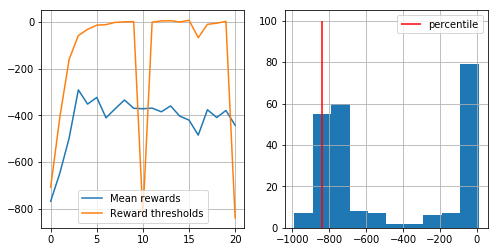

epoch  20


Percentile 69.00000
mean reward = -411.860, threshold=-14.190


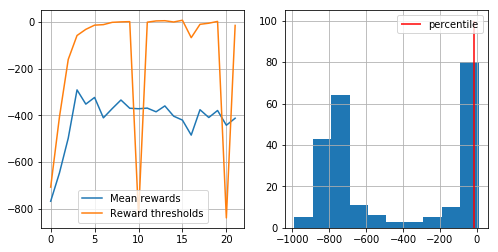

epoch  21


Percentile 68.00000
mean reward = -403.836, threshold=0.000


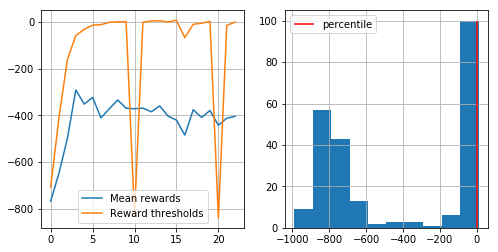

epoch  22


Percentile 67.00000
mean reward = -372.596, threshold=5.000


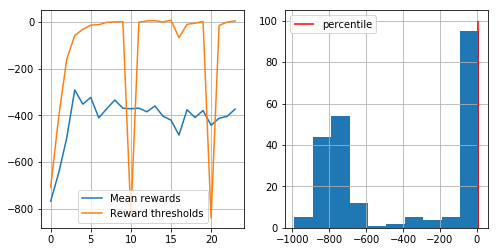

epoch  23


Percentile 66.00000
mean reward = -319.988, threshold=5.000


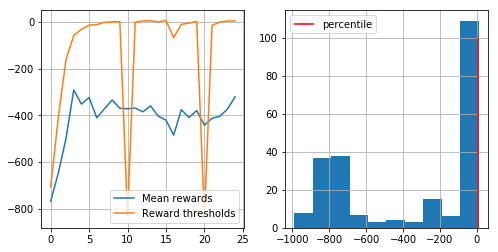

epoch  24


Percentile 65.00000
mean reward = -360.320, threshold=-1.000


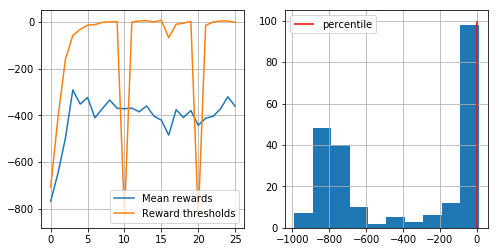

epoch  25


Percentile 64.00000
mean reward = -289.772, threshold=5.000


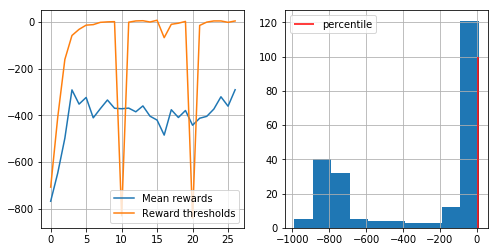

epoch  26


Percentile 63.00000
mean reward = -366.648, threshold=-17.260


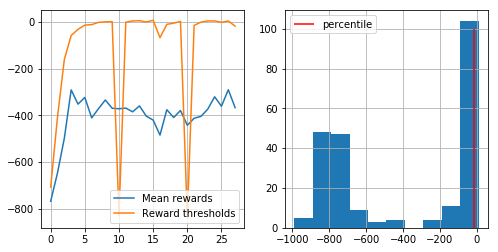

epoch  27


Percentile 62.00000
mean reward = -290.980, threshold=2.380


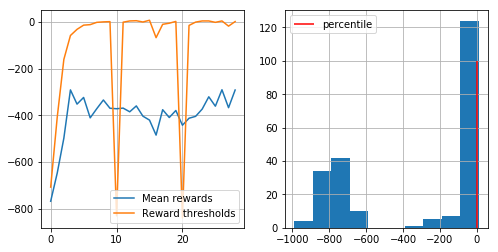

epoch  28


Percentile 61.00000
mean reward = -310.016, threshold=-3.110


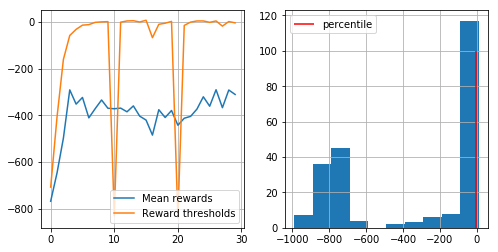

epoch  29


Percentile 85.00000
mean reward = -328.092, threshold=9.000


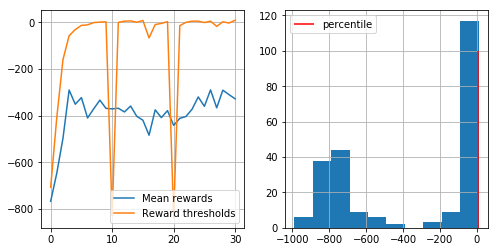

epoch  30


Percentile 59.00000
mean reward = -387.612, threshold=-133.360


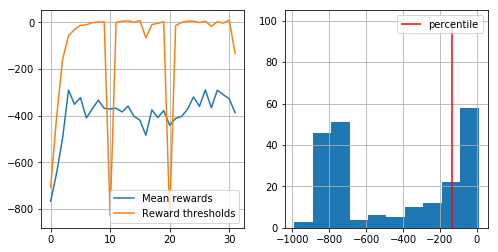

epoch  31


Percentile 58.00000
mean reward = -331.248, threshold=-57.740


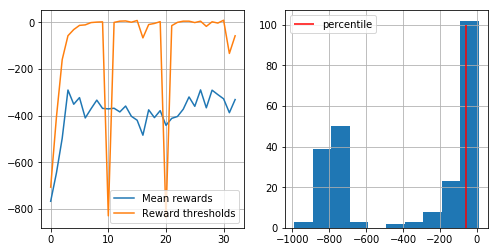

epoch  32


Percentile 57.00000
mean reward = -266.292, threshold=-15.070


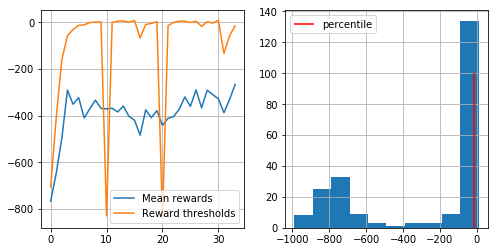

epoch  33


Percentile 56.00000
mean reward = -265.020, threshold=-9.000


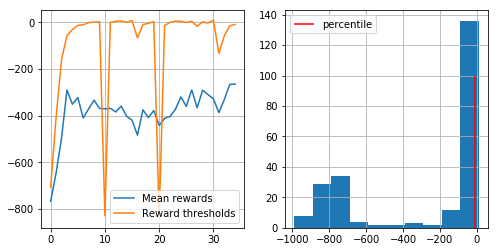

epoch  34


Percentile 55.00000
mean reward = -236.676, threshold=0.950


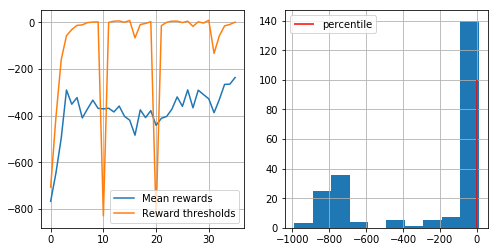

epoch  35


Percentile 54.00000
mean reward = -252.068, threshold=-4.540


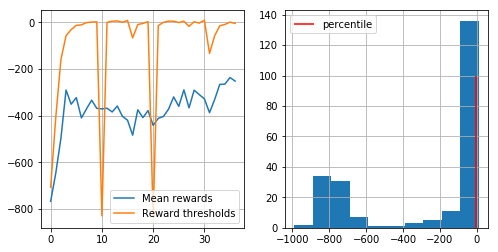

epoch  36


Percentile 53.00000
mean reward = -271.084, threshold=-1.000


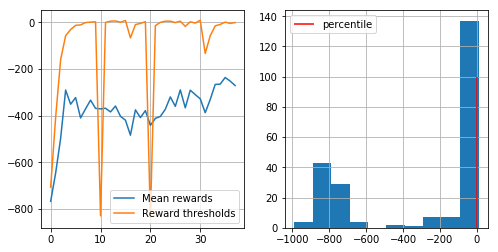

epoch  37


Percentile 52.00000
mean reward = -275.620, threshold=-7.520


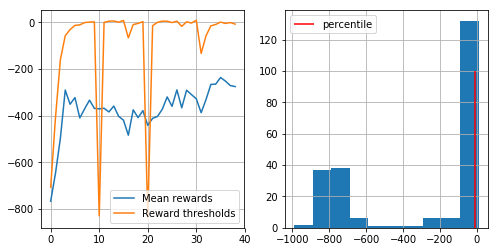

epoch  38


Percentile 51.00000
mean reward = -264.020, threshold=-8.000


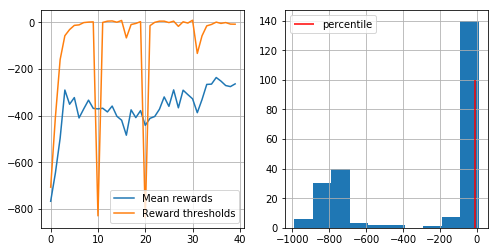

epoch  39


Percentile 10.00000
mean reward = -247.916, threshold=-812.000


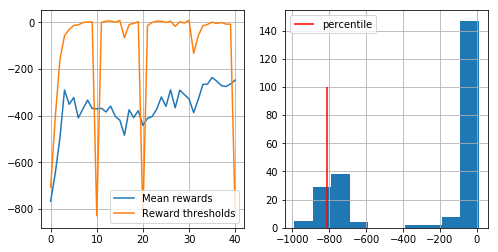

epoch  40


Percentile 49.00000
mean reward = -230.124, threshold=-7.990


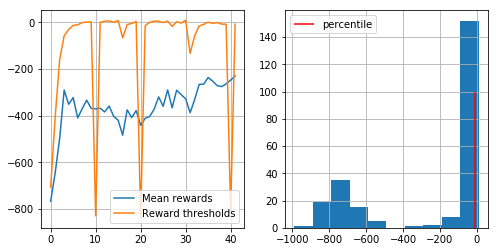

epoch  41


Percentile 48.00000
mean reward = -257.264, threshold=-11.960


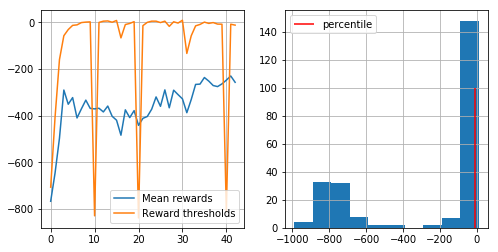

epoch  42


Percentile 47.00000
mean reward = -222.784, threshold=-6.000


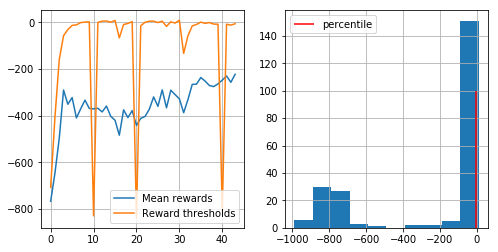

epoch  43


Percentile 46.00000
mean reward = -220.824, threshold=-4.000


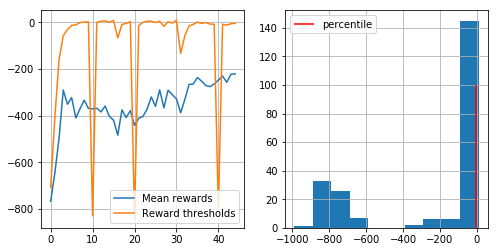

epoch  44


Percentile 85.00000
mean reward = -243.356, threshold=9.000


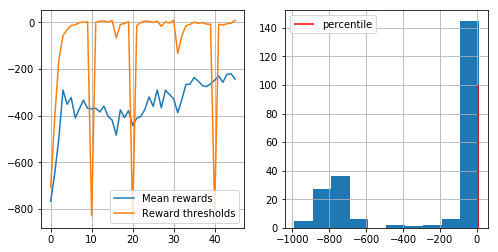

epoch  45


Percentile 44.00000
mean reward = -371.952, threshold=-427.160


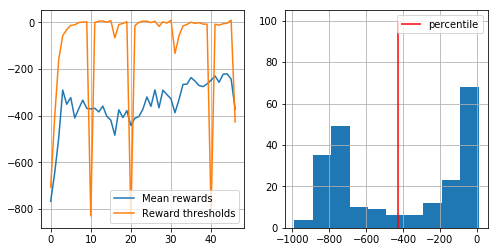

epoch  46


Percentile 43.00000
mean reward = -217.248, threshold=-149.930


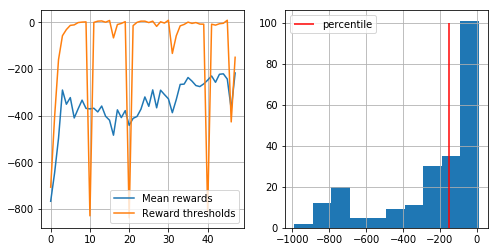

epoch  47


Percentile 42.00000
mean reward = -185.020, threshold=-80.840


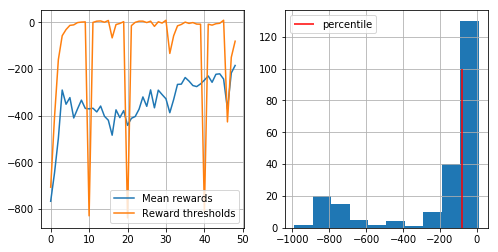

epoch  48


Percentile 41.00000
mean reward = -146.400, threshold=-38.910


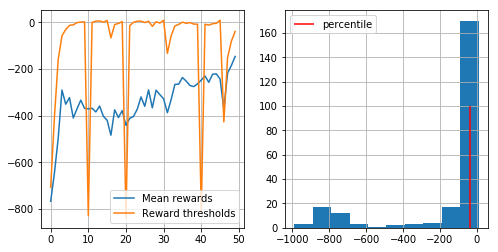

epoch  49


Percentile 10.00000
mean reward = -122.836, threshold=-531.300


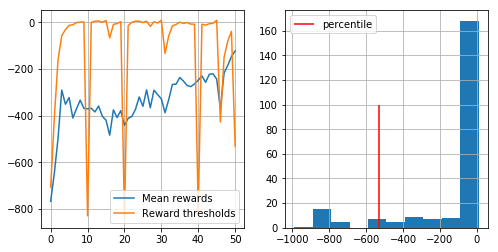

epoch  50


Percentile 39.00000
mean reward = -71.324, threshold=-19.890


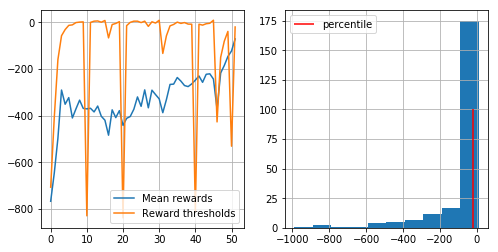

epoch  51


Percentile 38.00000
mean reward = -159.224, threshold=-27.000


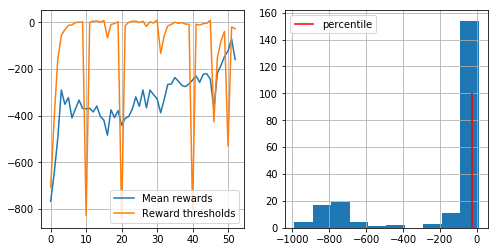

epoch  52


Percentile 37.00000
mean reward = -109.620, threshold=-9.870


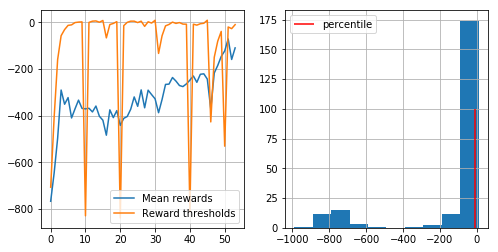

epoch  53


Percentile 36.00000
mean reward = -120.416, threshold=-18.720


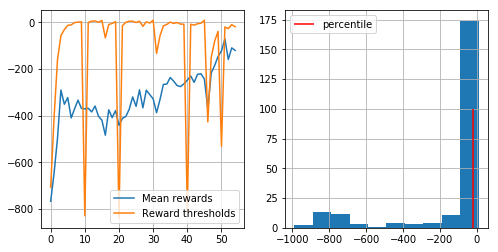

epoch  54


Percentile 35.00000
mean reward = -149.788, threshold=-25.000


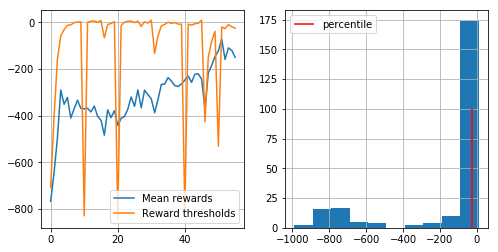

epoch  55


Percentile 34.00000
mean reward = -133.640, threshold=-16.340


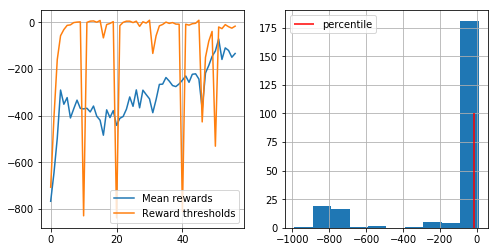

epoch  56


Percentile 33.00000
mean reward = -131.696, threshold=-14.660


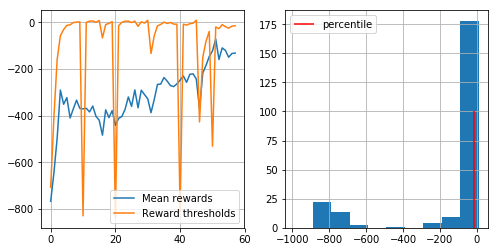

epoch  57


Percentile 32.00000
mean reward = -106.232, threshold=-9.000


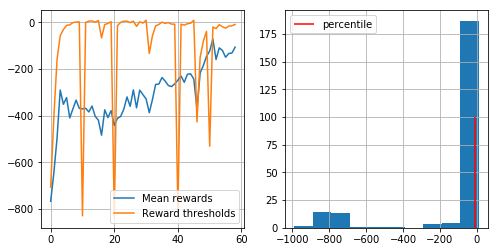

epoch  58


Percentile 31.00000
mean reward = -108.000, threshold=-14.000


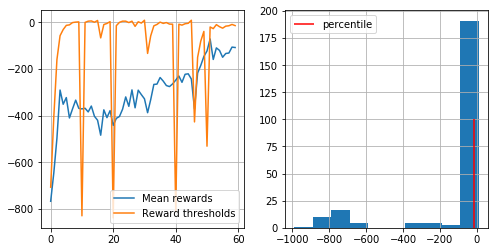

epoch  59


Percentile 85.00000
mean reward = -134.660, threshold=9.000


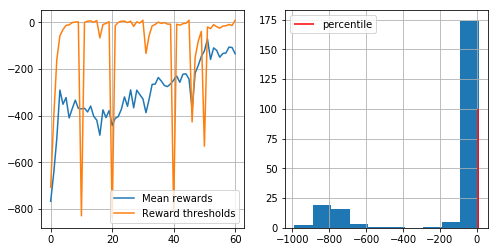

epoch  60


Percentile 30.00000
mean reward = -288.528, threshold=-467.300


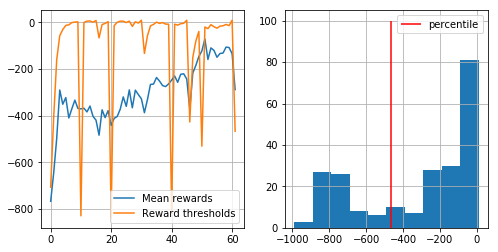

epoch  61


Percentile 30.00000
mean reward = -157.148, threshold=-214.600


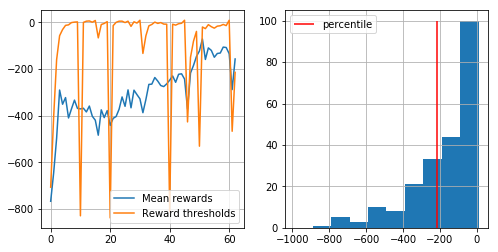

epoch  62


Percentile 30.00000
mean reward = -91.096, threshold=-121.000


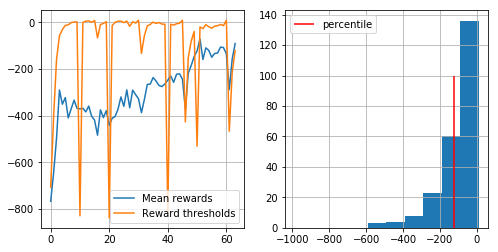

epoch  63


Percentile 20.00000
mean reward = -38.580, threshold=-76.200


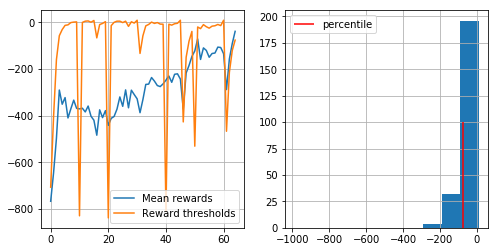

epoch  64


Percentile 20.00000
mean reward = -26.584, threshold=-47.200


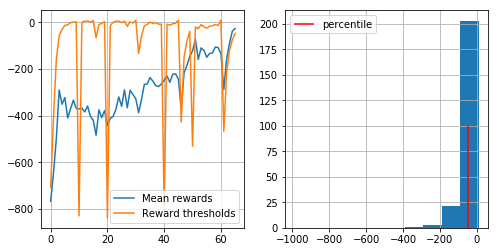

epoch  65


Percentile 20.00000
mean reward = -22.872, threshold=-40.000


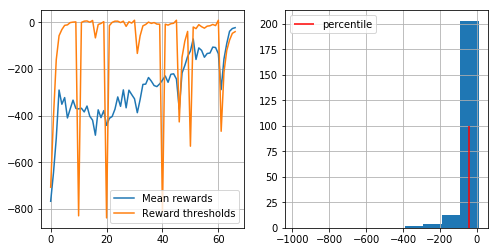

epoch  66


Percentile 20.00000
mean reward = -14.104, threshold=-23.600


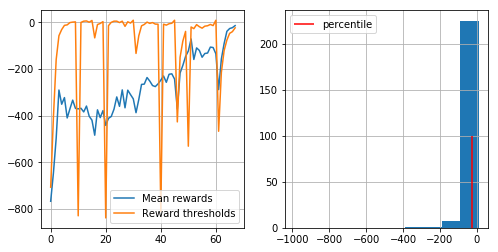

epoch  67
Percentile 20.00000


mean reward = -8.764, threshold=-19.000


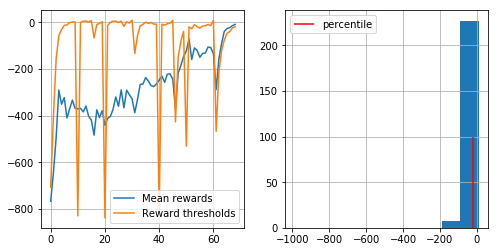

epoch  68
Percentile 20.00000


mean reward = -8.496, threshold=-19.000


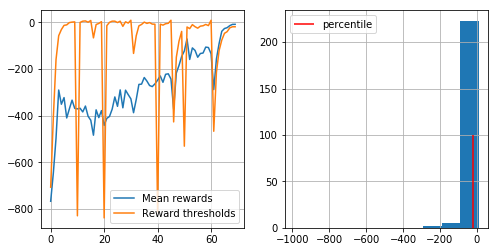

epoch  69
Percentile 10.00000


mean reward = -7.968, threshold=-28.600


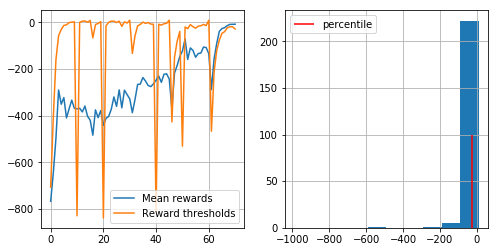

epoch  70
Percentile 10.00000
mean reward = -4.408, threshold=-22.000


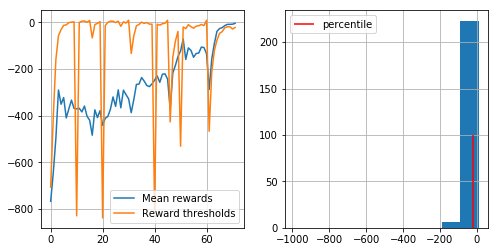

epoch  71
Percentile 10.00000


mean reward = -3.984, threshold=-21.000


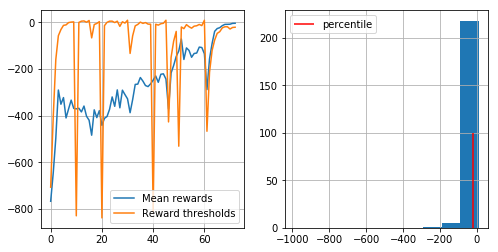

epoch  72
Percentile 20.00000
mean reward = -5.760, threshold=-9.000


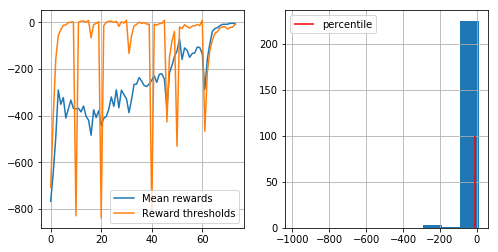

epoch  73
Percentile 10.00000


mean reward = -4.692, threshold=-24.100


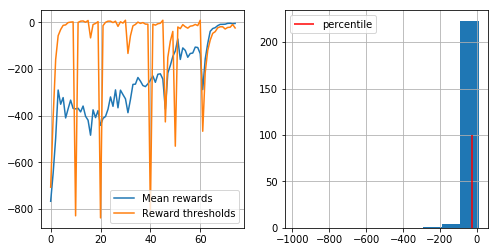

epoch  74
Percentile 20.00000


mean reward = -8.852, threshold=-8.000


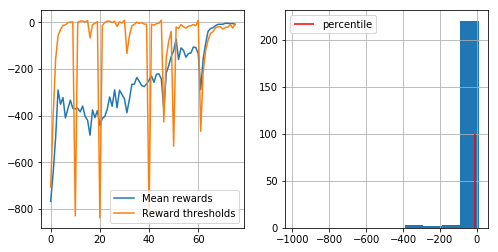

epoch  75
Percentile 10.00000


mean reward = -2.940, threshold=-17.000


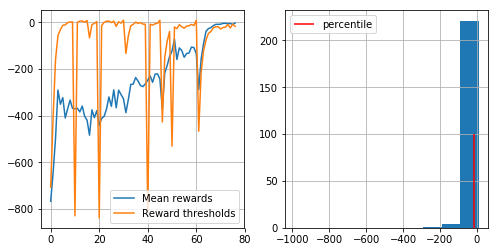

epoch  76
Percentile 20.00000


mean reward = -7.876, threshold=-12.000


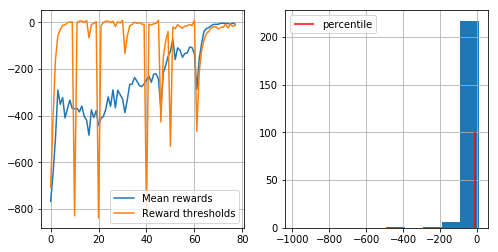

epoch  77
Percentile 20.00000


mean reward = -10.336, threshold=-9.000


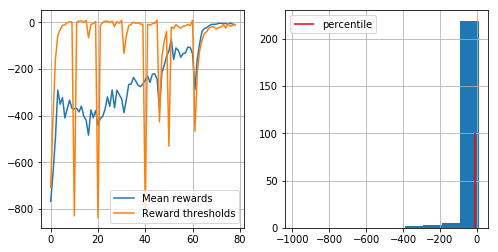

epoch  78
Percentile 10.00000


mean reward = -4.340, threshold=-31.300


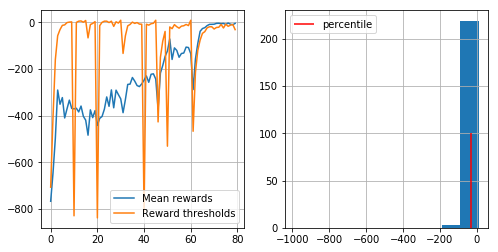

epoch  79
Percentile 10.00000


mean reward = -3.176, threshold=-19.600


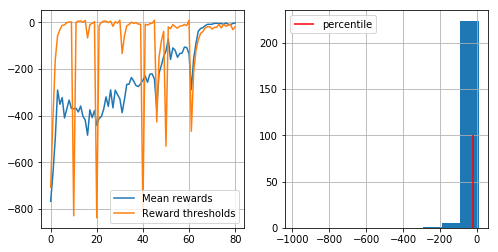

epoch  80
Percentile 20.00000


mean reward = -9.996, threshold=-13.200


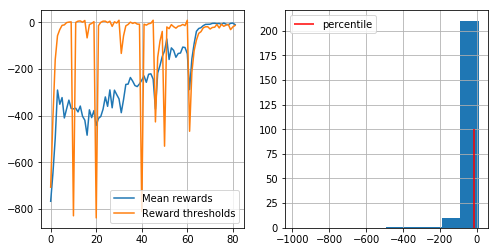

epoch  81
Percentile 20.00000


mean reward = -10.368, threshold=-9.000


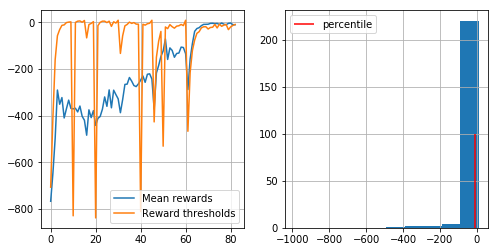

epoch  82
Percentile 20.00000


mean reward = -11.136, threshold=-10.200


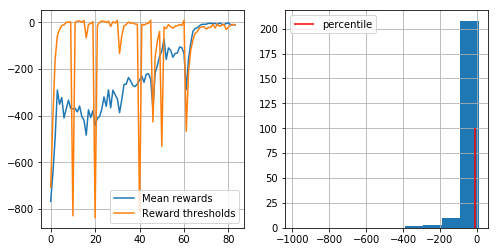

epoch  83
Percentile 20.00000


mean reward = -8.680, threshold=-9.000


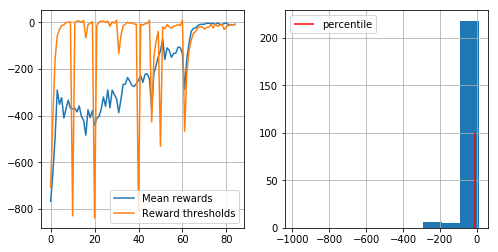

epoch  84
Percentile 20.00000


mean reward = -6.428, threshold=-11.000


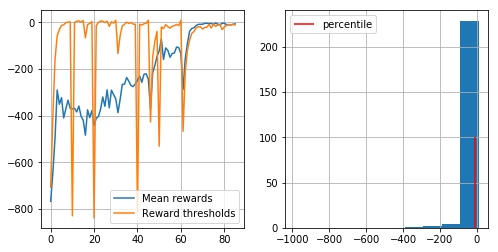

epoch  85
Percentile 20.00000


mean reward = -10.652, threshold=-9.000


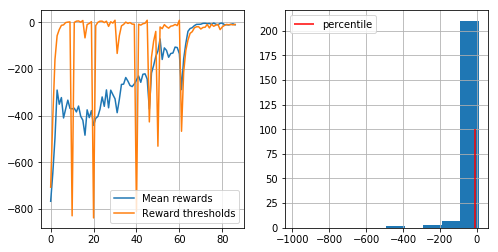

epoch  86
Percentile 20.00000


mean reward = -12.028, threshold=-9.000


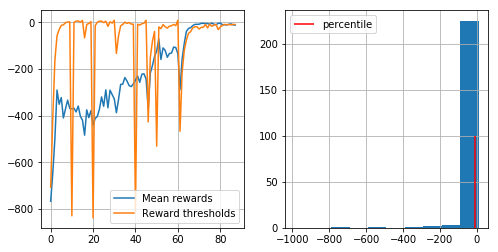

epoch  87
Percentile 20.00000


mean reward = -10.812, threshold=-14.000


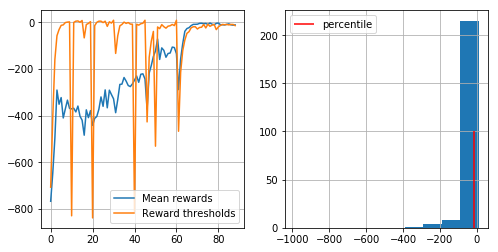

epoch  88
Percentile 10.00000
mean reward = -3.224, threshold=-22.000


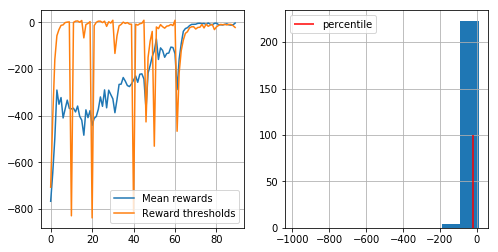

epoch  89
Percentile 10.00000


mean reward = -3.272, threshold=-26.000


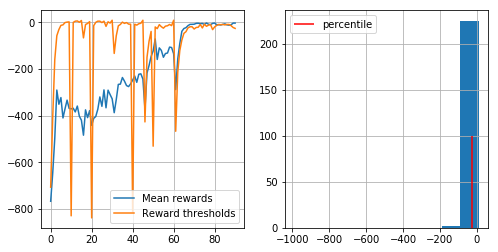

epoch  90
Percentile 10.00000
mean reward = -1.772, threshold=-16.000


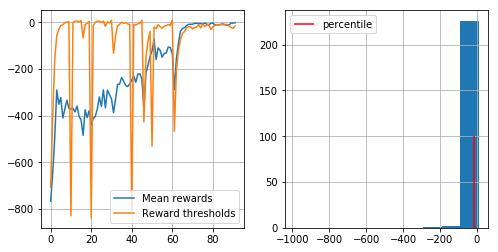

epoch  91
Percentile 10.00000
mean reward = -0.488, threshold=-14.100


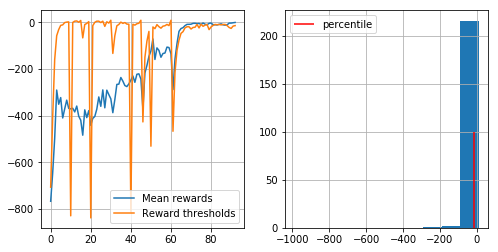

epoch  92
Percentile 10.00000
mean reward = 0.656, threshold=-14.000


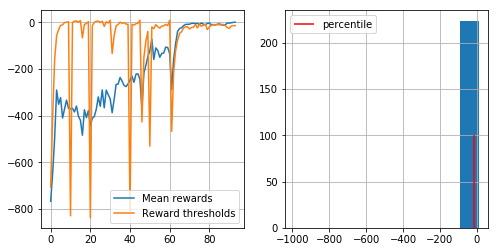

epoch  93
Percentile 10.00000


mean reward = -1.592, threshold=-13.100


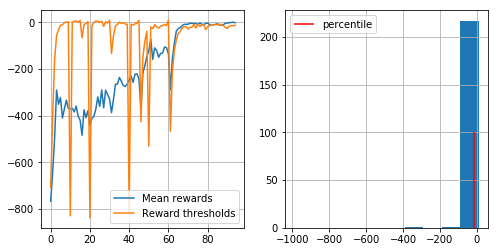

epoch  94
Percentile 10.00000
mean reward = -2.992, threshold=-14.100


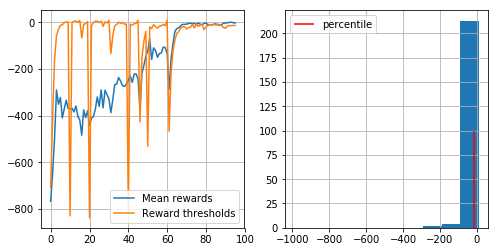

epoch  95
Percentile 10.00000


mean reward = -3.104, threshold=-23.000


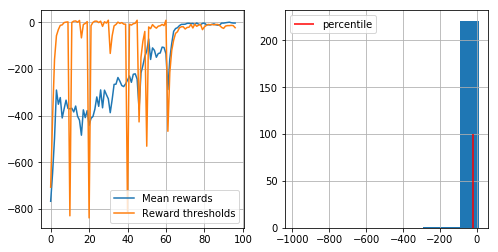

epoch  96
Percentile 10.00000
mean reward = -2.012, threshold=-16.100


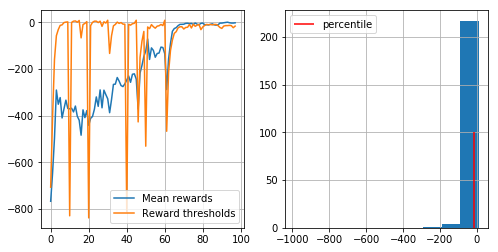

epoch  97
Percentile 10.00000
mean reward = 0.828, threshold=-9.000


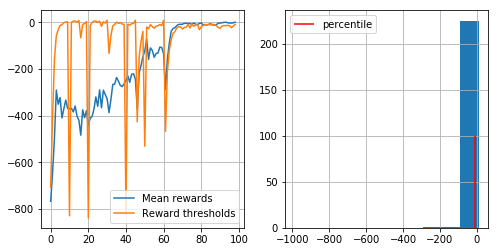

epoch  98
Percentile 10.00000


mean reward = -4.892, threshold=-27.100


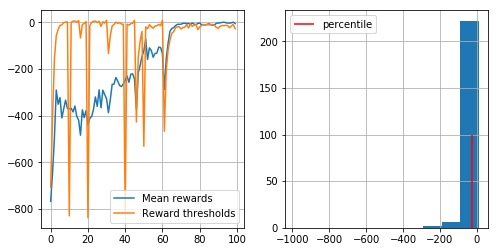

epoch  99
Percentile 10.00000


mean reward = -8.028, threshold=-30.000


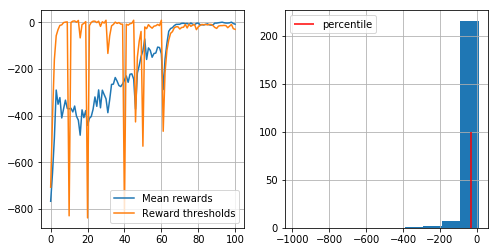

epoch  100
Percentile 10.00000
mean reward = -3.656, threshold=-17.100


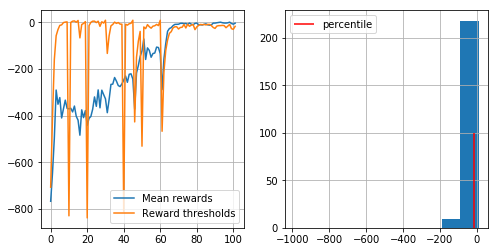

epoch  101
Percentile 10.00000
mean reward = -3.028, threshold=-23.300


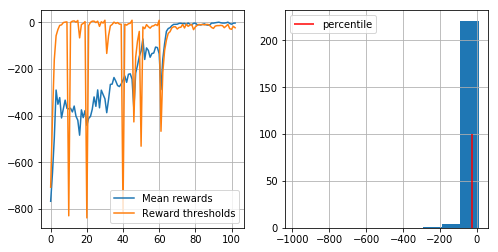

epoch  102
Percentile 10.00000


mean reward = -2.016, threshold=-17.200


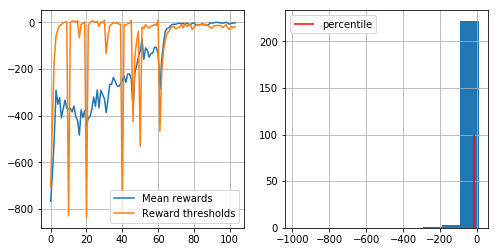

epoch  103
Percentile 10.00000


mean reward = -1.956, threshold=-15.200


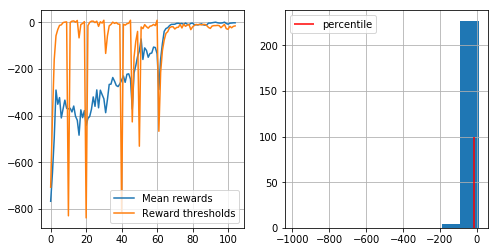

epoch  104


Percentile 20.00000
mean reward = -5.412, threshold=-7.200


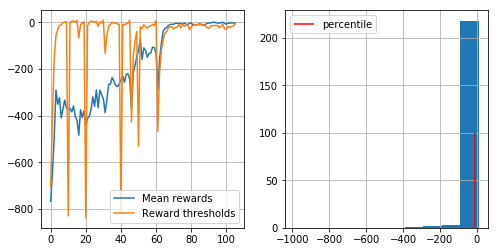

epoch  105
Percentile 10.00000


mean reward = -4.676, threshold=-28.100


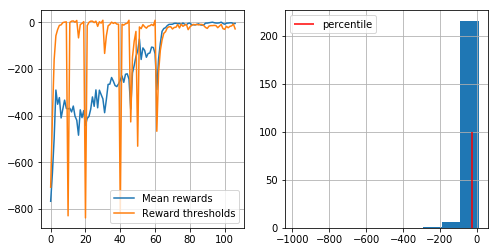

epoch  106
Percentile 20.00000
mean reward = -5.336, threshold=-7.200


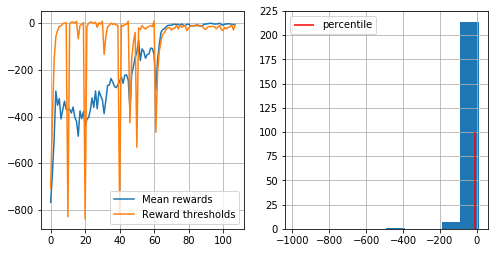

epoch  107


Percentile 20.00000
mean reward = -18.352, threshold=-10.200


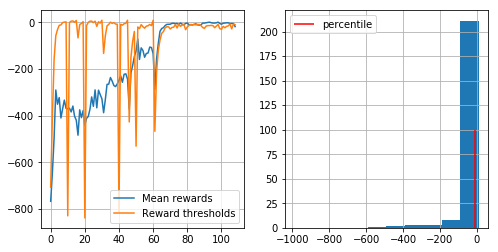

epoch  108
Percentile 10.00000
mean reward = -2.816, threshold=-15.100


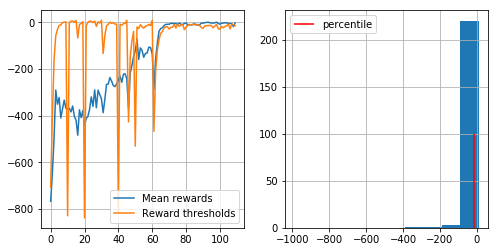

epoch  109
Percentile 10.00000
mean reward = -2.196, threshold=-22.100


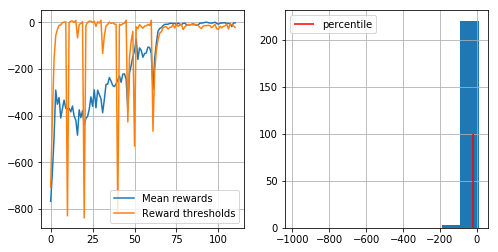

epoch  110
Percentile 10.00000
mean reward = -1.960, threshold=-14.000


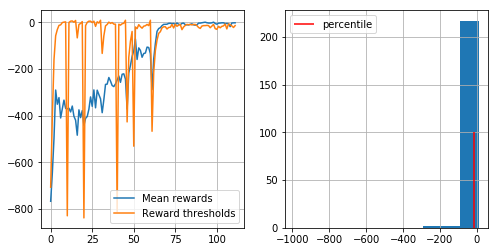

epoch  111
Percentile 10.00000


mean reward = -2.560, threshold=-17.100


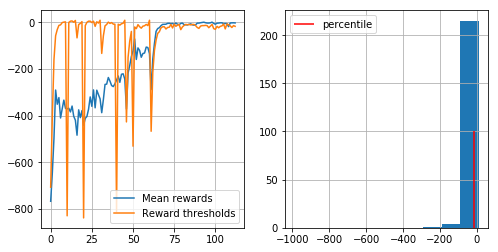

epoch  112
Percentile 10.00000
mean reward = -0.220, threshold=-10.600


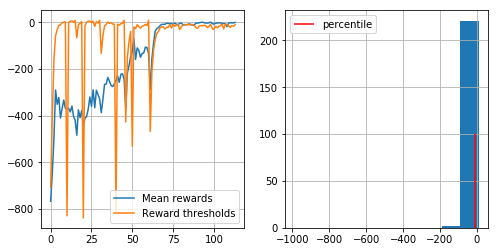

epoch  113
Percentile 20.00000


mean reward = -5.028, threshold=-6.000


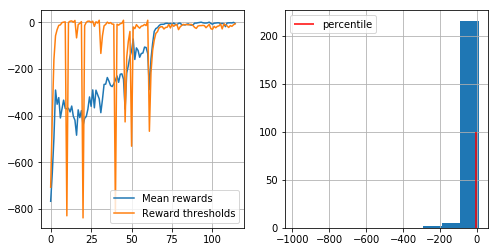

epoch  114
Percentile 10.00000
mean reward = -0.508, threshold=-15.100


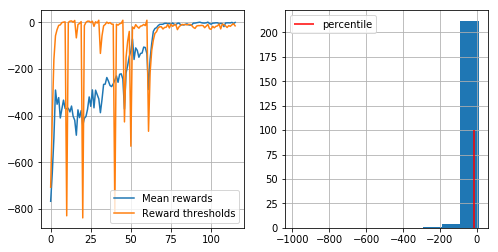

epoch  115
Percentile 10.00000
mean reward = -0.152, threshold=-15.000


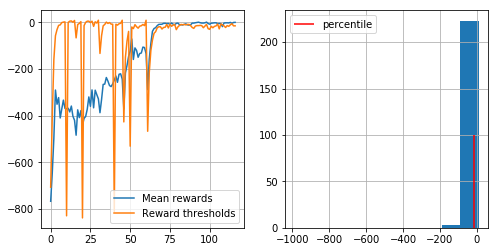

epoch  116
Percentile 10.00000
mean reward = -0.032, threshold=-17.100


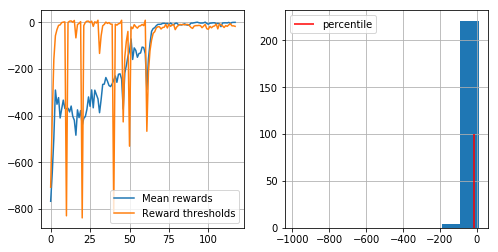

epoch  117
Percentile 10.00000


mean reward = -3.960, threshold=-23.100


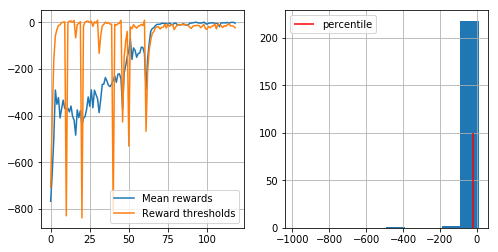

epoch  118
Percentile 10.00000


mean reward = -4.880, threshold=-21.000


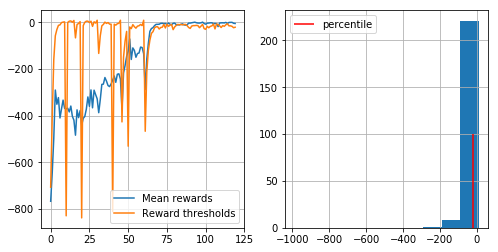

epoch  119
Percentile 10.00000
mean reward = -2.488, threshold=-23.100


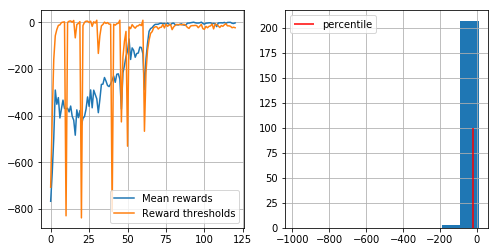

epoch  120
Percentile 20.00000
mean reward = -5.660, threshold=-8.000


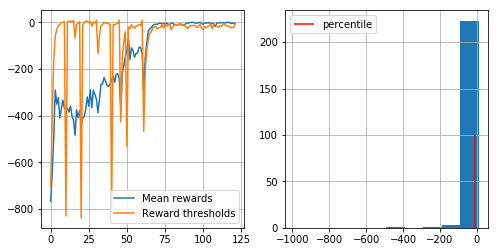

epoch  121
Percentile 10.00000
mean reward = -3.260, threshold=-27.000


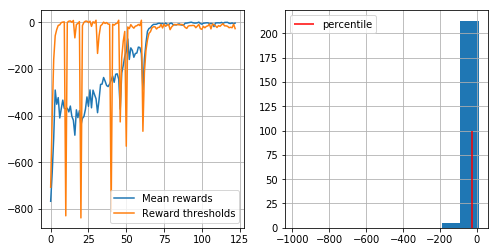

epoch  122
Percentile 10.00000
mean reward = -3.180, threshold=-18.000


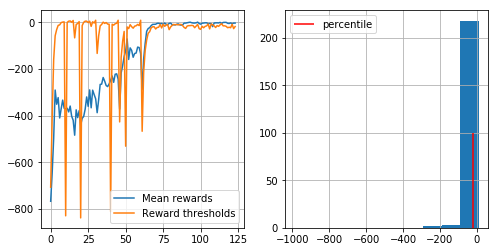

epoch  123
Percentile 10.00000


mean reward = -4.336, threshold=-29.100


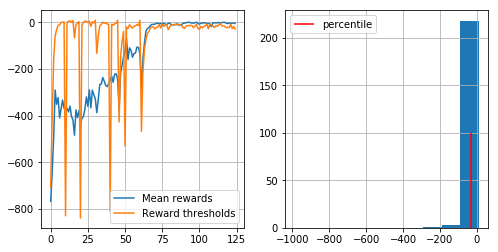

epoch  124


Percentile 20.00000
mean reward = -16.904, threshold=-20.200


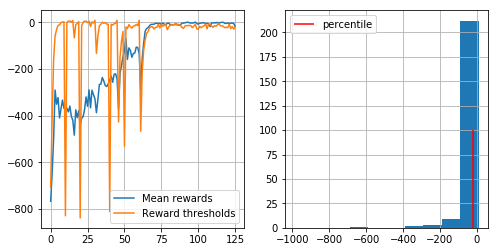

epoch  125
Percentile 20.00000


mean reward = -9.896, threshold=-9.200


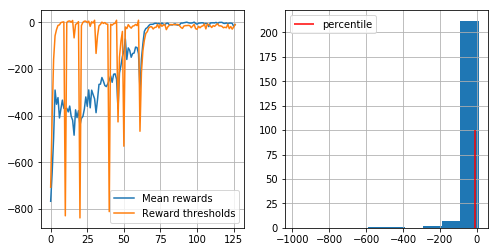

epoch  126
Percentile 20.00000
mean reward = -7.396, threshold=-13.200


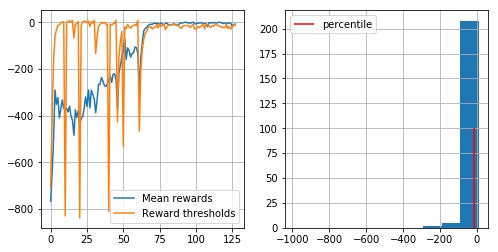

epoch  127
Percentile 10.00000
mean reward = -4.092, threshold=-22.200


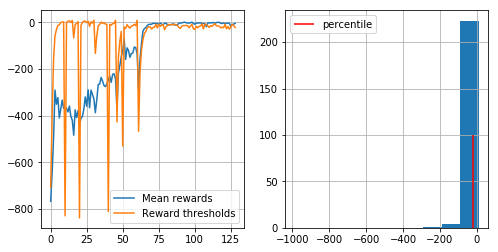

epoch  128
Percentile 10.00000


mean reward = -1.740, threshold=-19.000


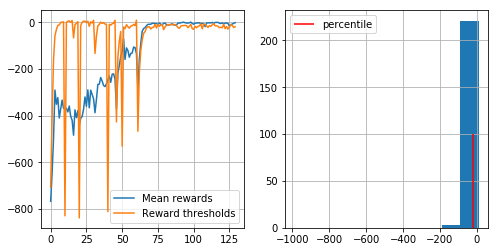

epoch  129
Percentile 10.00000


mean reward = -4.840, threshold=-25.000


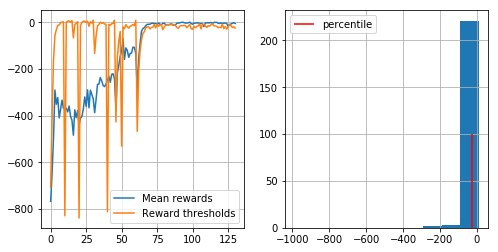

epoch  130
Percentile 10.00000


mean reward = -1.232, threshold=-20.100


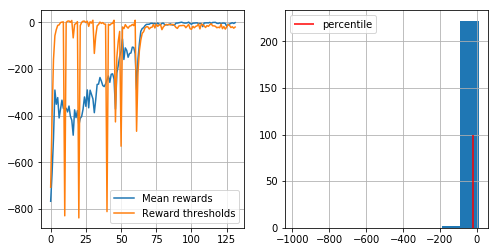

epoch  131
Percentile 10.00000


mean reward = -3.924, threshold=-23.000


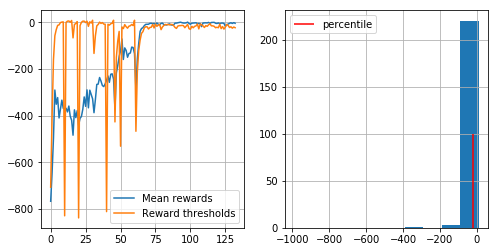

epoch  132
Percentile 20.00000


mean reward = -8.336, threshold=-9.200


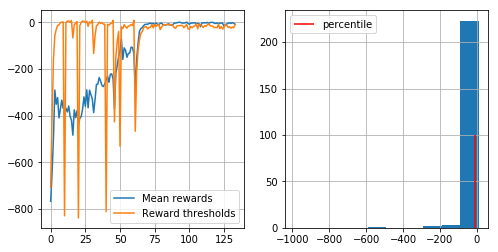

epoch  133
Percentile 10.00000
mean reward = -4.904, threshold=-27.100


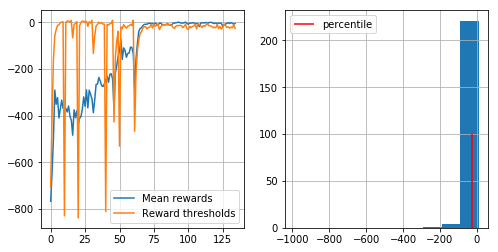

epoch  134
Percentile 10.00000
mean reward = -3.236, threshold=-23.000


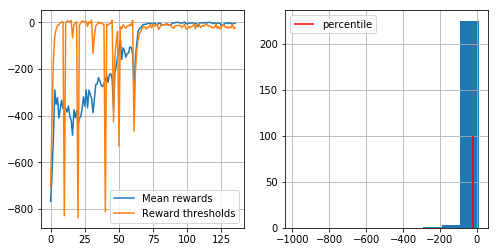

epoch  135
Percentile 10.00000
mean reward = -1.752, threshold=-20.200


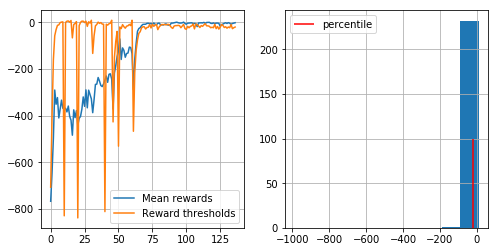

epoch  136
Percentile 10.00000


mean reward = -4.428, threshold=-23.000


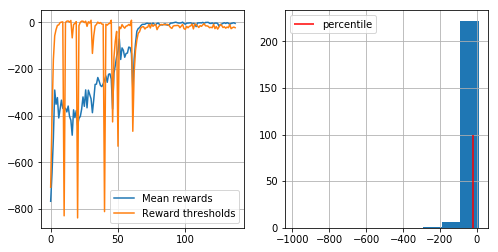

epoch  137
Percentile 20.00000


mean reward = -5.716, threshold=-12.000


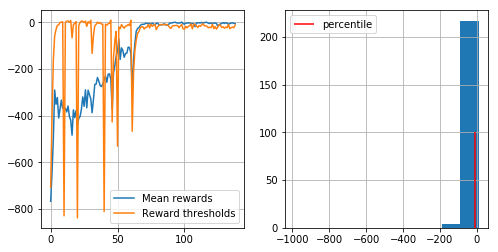

epoch  138
Percentile 10.00000
mean reward = -1.488, threshold=-19.300


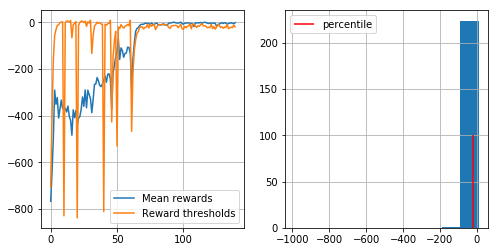

epoch  139
Percentile 10.00000


mean reward = -10.612, threshold=-34.100


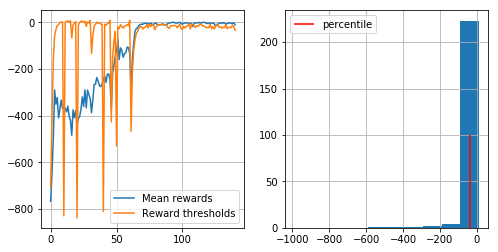

epoch  140
Percentile 10.00000


mean reward = -2.532, threshold=-17.200


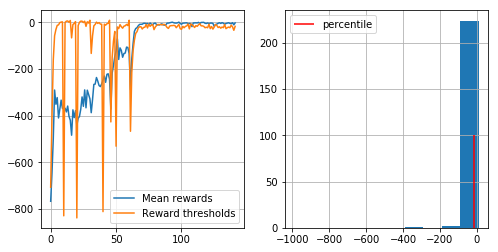

epoch  141
Percentile 10.00000
mean reward = -1.372, threshold=-16.100


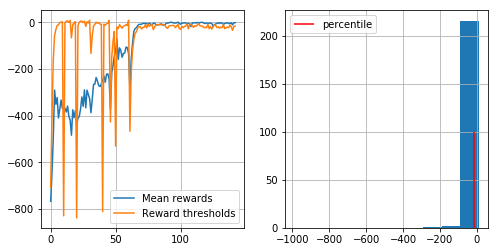

epoch  142


Percentile 10.00000
mean reward = -3.900, threshold=-18.100


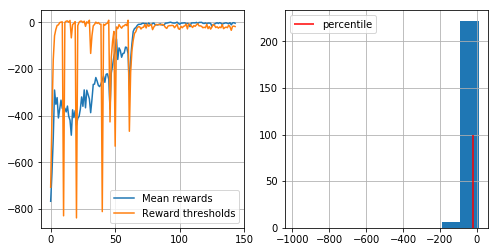

epoch  143
Percentile 10.00000
mean reward = -2.404, threshold=-16.100


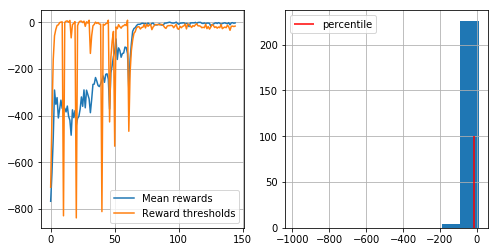

epoch  144
Percentile 10.00000


mean reward = -4.952, threshold=-25.100


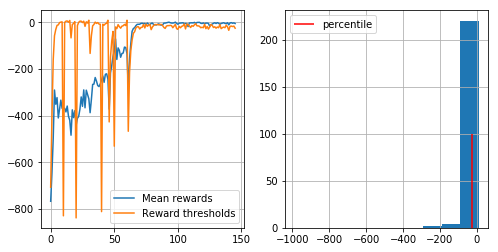

epoch  145
Percentile 10.00000
mean reward = -3.064, threshold=-18.100


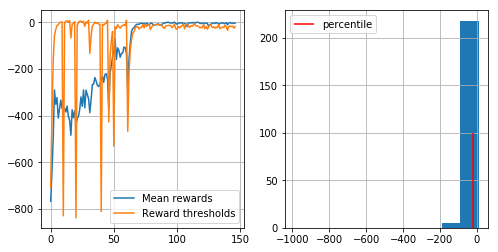

epoch  146
Percentile 10.00000
mean reward = 0.432, threshold=-8.100


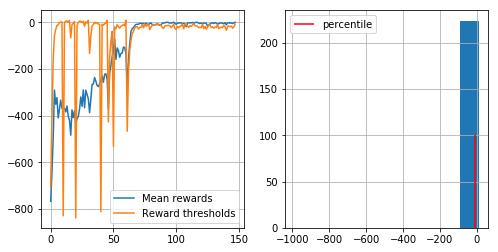

epoch  147
Percentile 10.00000
mean reward = -1.908, threshold=-16.100


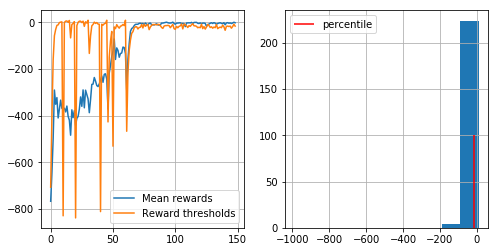

epoch  148
Percentile 10.00000


mean reward = -3.700, threshold=-16.300


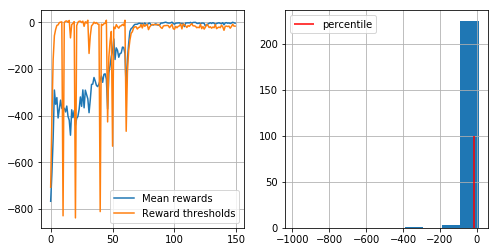

epoch  149


In [35]:
train_method(p_policy=g_policy, 
             p_samples=250, 
             p_percentile=70, 
             p_smoothing=0.01)
